# Masked Linear Iterative Neural Network: 2D to X-axis Transformation

This notebook implements a masked linear iterative neural network that:
1. Maps points from the cartesian plane (x, y) to the (x, sin(x))
2. Ensures that the inverse transformation maps points from (x,sin(x)) to (x,sin(x)+1)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import sys
# Add the parent directory to sys.path to find the iterativenn module
sys.path.append('..')
from iterativenn.iterativenn.src.iterativenn import utils
from iterativenn.iterativenn.src.iterativenn.nn_modules.MaskedLinear import MaskedLinear

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Jump Here for Hyperparameter Settings
hidden_size = 5     # Number of hidden dimensions (this will add dimensions to the vectors)
activation = 'tanhshrink'  # Activation function: 'tanhshrink', 'tanh', 'relu', 'leaky_relu', 'sigmoid'
num_iterations = 5  # Number of iterations through the network

# Hidden size parameter controls:
# 1. The number of zeros added to input/output tensors (hidden_size dimensions will be added)
# 2. The input_size and output_size (will be 3 + hidden_size)
# 3. The last entry in row_sizes and col_sizes

# Activation function parameter controls:
# 1. The activation function used in the forward pass
# 2. The inverse activation function used in the inverse network

print(f"Using hidden_size = {hidden_size}")
print(f"Using num_iterations = {num_iterations}")
print(f"Using activation = {activation}")

Using hidden_size = 5
Using num_iterations = 5
Using activation = tanhshrink


## Data Generation

Generate training data with 2D points that will be mapped to the x-axis.

Input shape: torch.Size([2000, 8])
Target shape: torch.Size([2000, 8])
Input sample: tensor([ 4.1751, -2.4404,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])
Target sample: tensor([ 4.1751, -0.8591,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])


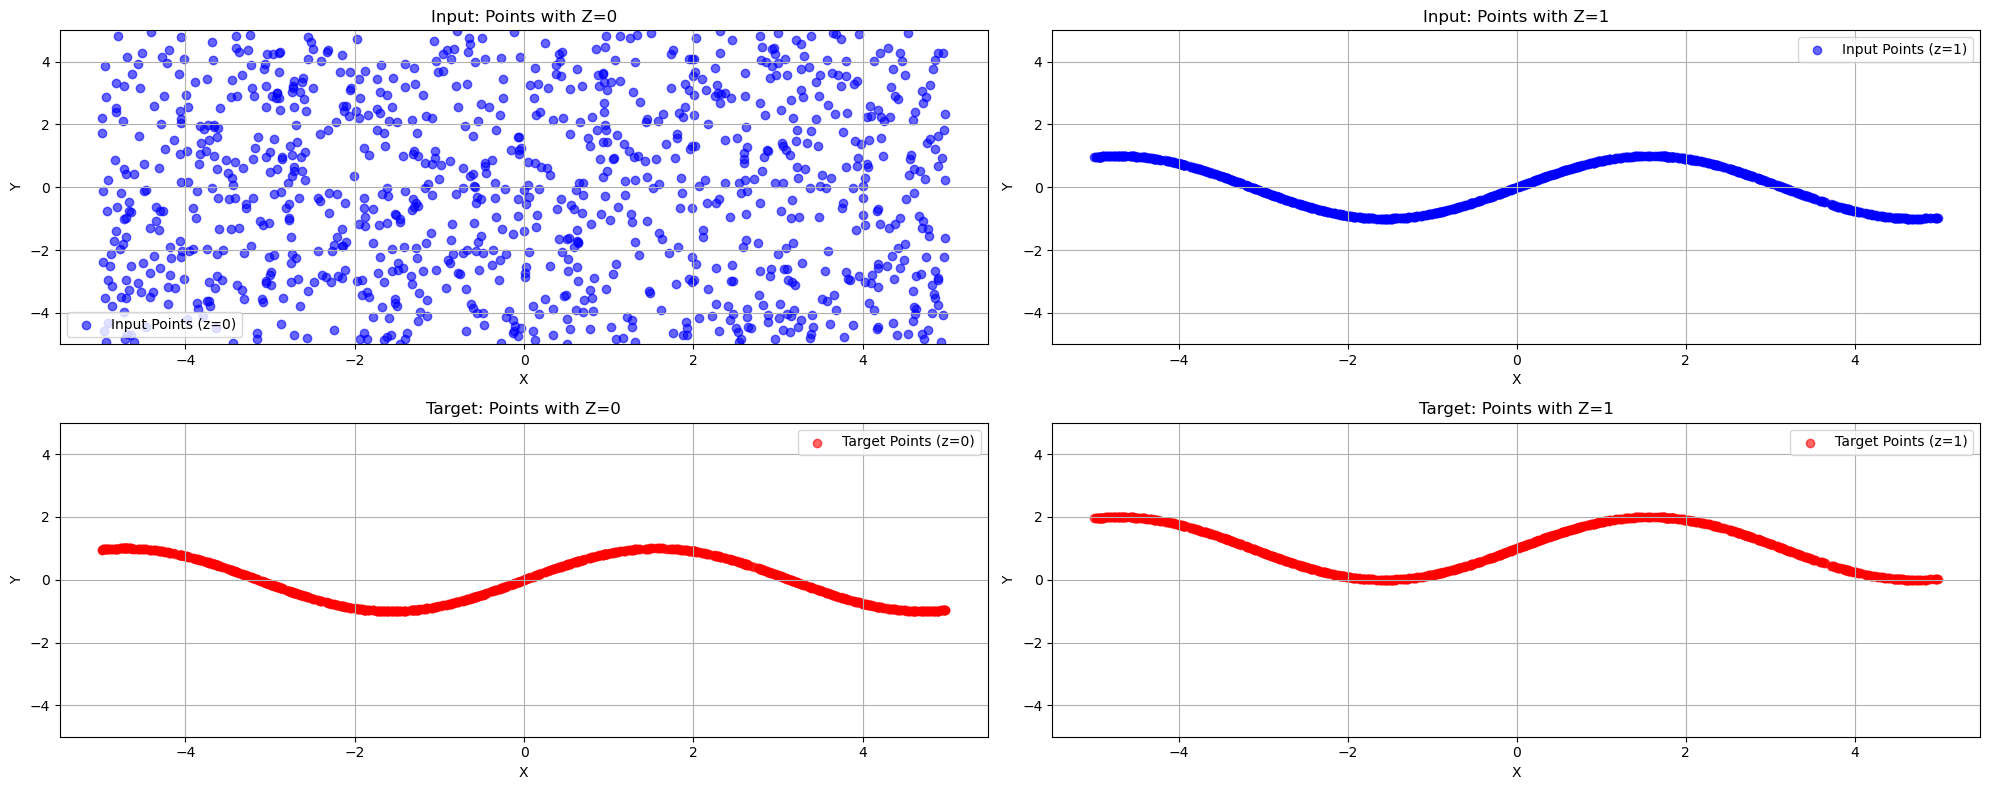

In [3]:
def generate_2d_data(n_samples=1000, x_range=(-5, 5), y_range=(-5, 5)):
    """Generate random 2D points and their corresponding x-axis projections"""
    
    # Generate random 2D points
    x = np.random.uniform(x_range[0], x_range[1], n_samples)
    y = np.random.uniform(y_range[0], y_range[1], n_samples)
    
    # Input: 2D points (x, y)
    input_points = np.column_stack([x, y])
    
    # Target: projected to x-axis (x, 0)
    target_points = np.column_stack([x, np.zeros_like(x)])
    
    return input_points, target_points

def generate_3d_data(n_samples=1000, hidden=1,x_range=(-5, 5), y_range=(-5, 5), z_range=(-5, 5)):
    """Generate random 3D points and their corresponding x-axis projections"""
    # Generate random 3D points with z=0 and their corresponding x-axis projections
    x1 = np.random.uniform(x_range[0], x_range[1], n_samples // 2)
    y1 = np.random.uniform(y_range[0], y_range[1], n_samples // 2)
    z1 = np.zeros(n_samples // 2)
    
    # Create a list of arrays for column stacking with the specified hidden_size
    input_set1_cols = [x1, y1, z1]
    target_set1_cols = [x1, np.sin(x1), np.zeros_like(x1)]
    
    # Add hidden dimensions
    for _ in range(hidden):
        input_set1_cols.append(np.zeros_like(x1))
        target_set1_cols.append(np.zeros_like(x1))
    
    # First set: (x, y, 0) + hidden zeros -> (x, sin(x), 0) + hidden zeros
    input_set1 = np.column_stack(input_set1_cols) #modify length here
    target_set1 = np.column_stack(target_set1_cols) #modify length here

    # Second set: (x, sin(x), 1) -> (x, sin(x)+1, 1) 
    x2 = np.random.uniform(x_range[0], x_range[1], n_samples // 2)
    y2 = np.sin(x2)
    z2 = np.ones(n_samples // 2)
    
    # Create a list of arrays for column stacking with the specified hidden_size
    input_set2_cols = [x2, y2, z2]
    target_set2_cols = [x2, y2 + 1, z2]
    
    # Add hidden dimensions
    for _ in range(hidden):
        input_set2_cols.append(np.zeros_like(x2))
        target_set2_cols.append(np.zeros_like(x2))
    
    input_set2 = np.column_stack(input_set2_cols) #modify length here
    target_set2 = np.column_stack(target_set2_cols) #modify length here

    # Combine both sets
    input_points = np.vstack([input_set1, input_set2])
    target_points = np.vstack([target_set1, target_set2])

    return input_points, target_points

def generate_3d_data_convex(n_samples=1000, hidden=1, x_range=(-5, 5), y_range=(-5, 5), z_range=(-5, 5)):
    """Generate random 3D points and their corresponding transformations"""
    # Generate random 3D points with z=0 and their corresponding transformations
    # Generate x2, y2 first to use for convex combinations
    x2_temp1 = np.random.uniform(x_range[0], x_range[1], n_samples // 2)
    y2_temp1 = np.sin(x2_temp1)

    x2_temp2 = np.random.uniform(x_range[0], x_range[1], n_samples // 2)
    y2_temp2 = np.sin(x2_temp2)

    # Generate convex combination weights
    alpha = np.random.uniform(0, 1, n_samples // 2)
    beta = np.random.uniform(0, 1, n_samples // 2)
    
    # Create convex combinations
    x1 = alpha * x2_temp1 + (1 - alpha) * x2_temp2
    y1 = beta * y2_temp1 + (1 - beta) * y2_temp2
    z1 = np.zeros(n_samples // 2)
    
    # First set: (x, y, 0) -> (x, sin(x), 0)
    input_set1 = np.column_stack([x1, y1, z1])
    target_set1 = np.column_stack([x1, np.sin(x1), np.zeros_like(x1)])

    # Second set: (x, sin(x), 1) -> (x, sin(x)+1, 1) 
    x2 = np.random.uniform(x_range[0], x_range[1], n_samples // 2)
    y2 = np.sin(x2)
    z2 = np.ones(n_samples // 2)
    
    input_set2 = np.column_stack([x2, y2, z2])
    target_set2 = np.column_stack([x2, y2 + 1, z2])

    # Combine both sets
    input_points = np.vstack([input_set1, input_set2])
    target_points = np.vstack([target_set1, target_set2])

    return input_points, target_points

# Generate training data
n_samples = 2000
input_data, target_data = generate_3d_data(n_samples, hidden_size)

# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)
target_tensor = torch.tensor(target_data, dtype=torch.float32).to(device)

print(f"Input shape: {input_tensor.shape}")
print(f"Target shape: {target_tensor.shape}")
print(f"Input sample: {input_tensor[0]}")
print(f"Target sample: {target_tensor[0]}")

# Visualize some of the data - split by z-coordinate
plt.figure(figsize=(20, 8))

# Split input data by z-coordinate
input_z0_mask = input_data[:, 2] == 0
input_z1_mask = input_data[:, 2] == 1

# Split target data by z-coordinate
target_z0_mask = target_data[:, 2] == 0
target_z1_mask = target_data[:, 2] == 1

# Plot 1: Input data with z=0
plt.subplot(2, 2, 1)
plt.scatter(input_data[input_z0_mask, 0], input_data[input_z0_mask, 1], alpha=0.6, c='blue', label='Input Points (z=0)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Input: Points with Z=0')
plt.legend()
plt.grid(True)
plt.ylim(-5, 5)

# Plot 2: Input data with z=1
plt.subplot(2, 2, 2)
plt.scatter(input_data[input_z1_mask, 0], input_data[input_z1_mask, 1], alpha=0.6, c='blue', label='Input Points (z=1)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Input: Points with Z=1')
plt.legend()
plt.grid(True)
plt.ylim(-5, 5)

# Plot 3: Target data with z=0
plt.subplot(2, 2, 3)
plt.scatter(target_data[target_z0_mask, 0], target_data[target_z0_mask, 1], alpha=0.6, c='red', label='Target Points (z=0)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Target: Points with Z=0')
plt.legend()
plt.grid(True)
plt.ylim(-5, 5)

# Plot 4: Target data with z=1
plt.subplot(2, 2, 4)
plt.scatter(target_data[target_z1_mask, 0], target_data[target_z1_mask, 1], alpha=0.6, c='red', label='Target Points (z=1)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Target: Points with Z=1')
plt.legend()
plt.grid(True)
plt.ylim(-5, 5)

plt.tight_layout()
plt.show()

## Network Architecture

Create a masked linear iterative neural network. The network will transform 2D points to x-axis points iteratively.

In [4]:
# Network configuration
input_size = 3 + hidden_size  # Base dimensions (x, y, z) + hidden dimensions #modify length here
output_size = 3 + hidden_size  # Base dimensions + hidden dimensions #modify length here

# Define the mask configuration for the MaskedLinear layer
# For a 3x3 transformation matrix, we need a simpler configuration

# Row sizes: we have base + hidden dimensions
row_sizes = [2, 1, hidden_size]  # Each output dimension treated separately #modify length here

# Column sizes: we have base + hidden dimensions
col_sizes = [2, 1, hidden_size]  # Both inputs contribute to outputs #modify length here

# Block types: Define how each block should behave
# We want a 2x2 transformation matrix with some structure
block_types = [['W','W','W'], 
               ['W','D','W'],
               ['W','W','W']]  

# Initialization types
initialization_types = [['G','G','G'], 
                        ['G', 1 ,'G'],
                        ['G','G','G']]  

# Trainable blocks
trainable = [['non-zero','non-zero','non-zero'], 
             ['non-zero', 0        ,'non-zero'],  
             ['non-zero','non-zero','non-zero']]  # All blocks are trainable except the last one

# Create the MaskedLinear layer
ml = MaskedLinear(input_size, output_size, bias=True)

masked_linear = ml.from_description(row_sizes=row_sizes,
                                    col_sizes=col_sizes,
                                    block_types=block_types,
                                    initialization_types=initialization_types,
                                    trainable=trainable)
print("MaskedLinear created successfully with custom configuration")


# Create the iterative neural network with configurable activation function
class ConditionalIterativeNet(nn.Module):
    def __init__(self, masked_linear, activation_type='tanhshrink'):
        super().__init__()
        self.masked_linear = masked_linear
        
        # Select activation function based on parameter
        if activation_type == 'tanhshrink':
            self.activation = nn.Tanhshrink()
        elif activation_type == 'tanh':
            self.activation = nn.Tanh()
        elif activation_type == 'relu':
            self.activation = nn.ReLU()
        elif activation_type == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation_type == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            # Default to Tanhshrink if unknown activation is specified
            print(f"Warning: Unknown activation '{activation_type}', using Tanhshrink instead.")
            self.activation = nn.Tanhshrink()
            
        self.activation_type = activation_type
    
    def forward(self, x, apply_activation=True):
        x = self.masked_linear(x)
        if apply_activation:
            x = self.activation(x)
        return x

# Create the network with the specified activation function
net = ConditionalIterativeNet(masked_linear, activation).to(device)

print("Network architecture:")
print(net)
print(f"Number of iterations: {num_iterations}")
print(f"Activation function: {activation}")

# Print weight matrix info
with torch.no_grad():
    current_weight = masked_linear.weight_0 + masked_linear.U * masked_linear.mask
    print(f"Initial weight matrix shape: {current_weight.shape}")
    print(f"Initial weight matrix:\n{current_weight}")
    print(f"Initial bias: {masked_linear.bias}")

MaskedLinear created successfully with custom configuration
Network architecture:
ConditionalIterativeNet(
  (masked_linear): MaskedLinear(in_features=8, out_features=8, bias=True)
  (activation): Tanhshrink()
)
Number of iterations: 5
Activation function: tanhshrink
Initial weight matrix shape: torch.Size([8, 8])
Initial weight matrix:
tensor([[ 2.3295, -0.8917,  0.7054, -0.1399,  0.5839, -0.3372,  0.2531, -0.2257],
        [ 0.5276, -0.5405,  0.4002, -0.2458,  0.5889,  1.0978, -0.1642,  0.7693],
        [ 0.7114,  0.9740,  1.0000, -2.4317,  0.6106,  0.6957, -0.3241,  0.0601],
        [-2.3273,  0.5078,  0.0065,  0.3101, -0.5310,  0.3992,  0.1567, -0.0737],
        [ 1.6538, -1.3969,  2.2037,  0.5250, -0.4355,  1.5894, -0.3207, -1.6365],
        [ 0.7511,  0.2420,  1.2050, -1.2587, -0.3986,  0.7640,  0.6803,  0.3688],
        [ 2.0459,  0.4566, -0.2582,  0.3629, -0.6967, -1.6077,  2.4560,  2.3883],
        [ 0.4415, -0.1663,  0.1207,  0.1714, -1.1249, -0.6472, -0.2631, -0.2530]])
Init

In [5]:
# Create dataset and dataloader
class TwoDDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

# Create training dataset and dataloader
train_dataset = TwoDDataset(input_tensor, target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")

Training dataset size: 2000
Number of batches: 32


## Training with Inverse Constraint

Train the network to map 2D points to x-axis while ensuring the inverse maps x-axis points back to y=1.

In [6]:
def create_inverse_network(net, masked_linear):
    """Create inverse transformation functions for 3D data"""
    
    # Get the weight matrix from the masked linear layer
    weights = masked_linear.weight_0 + masked_linear.U * masked_linear.mask
    biases = masked_linear.bias
    
    # For 3D data, we need to handle the full 3x3 transformation
    # Compute pseudo-inverse using SVD
    U, S, V = torch.svd(weights)
    
    # Create inverse singular value matrix with proper dimensionality
    S_inv = torch.zeros_like(V)
    for i in range(len(S)):
        if S[i] > 1e-15:
            S_inv[i, i] = 1.0 / S[i]
    
    # Compute pseudo-inverse
    inv_weight = V.mm(S_inv).mm(U.t())
    
    # Get the activation function type from the network
    activation_type = net.activation_type if hasattr(net, 'activation_type') else 'tanhshrink'
    
    def leaky_relu_inv(x, alpha=0.1):
        """Inverse of LeakyReLU"""
        return torch.where(x >= 0, x, x / alpha)
    
    def tanh_inv(x):
        """Inverse of Tanh"""
        # Apply clipping to avoid numerical issues
        x = torch.clamp(x, -0.99999, 0.99999)
        return 0.5 * torch.log((1 + x) / (1 - x))
    
    def sigmoid_inv(x):
        """Inverse of Sigmoid"""
        # Apply clipping to avoid numerical issues
        x = torch.clamp(x, 0.00001, 0.99999)
        return torch.log(x / (1 - x))
    
    def relu_inv(x):
        """Inverse of ReLU"""
        # Note: ReLU is not invertible for negative inputs, so we assume x >= 0
        return x
    
    def tanhshrink_inv(x):
        """Inverse of Tanhshrink"""
        # Tanhshrink(x) = x - tanh(x)
        # Approximate inverse by numerical approach
        # Start with x as the initial guess
        x_approx = x
        
        # For more accurate inversion, you'd use an iterative numerical method here
        # This is a simple approximation
        x_tanh = torch.tanh(x_approx)
        return x_approx + x_tanh
    
    def get_activation_inverse(x, act_type):
        """Apply the correct inverse activation based on the type"""
        if act_type == 'tanhshrink':
            return tanhshrink_inv(x)
        elif act_type == 'tanh':
            return tanh_inv(x)
        elif act_type == 'relu':
            return relu_inv(x)
        elif act_type == 'leaky_relu':
            return leaky_relu_inv(x)
        elif act_type == 'sigmoid':
            return sigmoid_inv(x)
        else:
            # Default to tanhshrink inverse
            return tanhshrink_inv(x)
    
    def inverse_network(y, iterations):
        """Apply inverse transformation iteratively for 3D data"""
        # Convert to tensor if numpy array
        if isinstance(y, np.ndarray):
            y = torch.tensor(y, dtype=torch.float32)
        
        for _ in range(iterations):
            # Apply inverse activation first, then subtract bias, then apply inverse weight
            y_inv_act = get_activation_inverse(y, activation_type)
            if biases is not None:
                y_inv_act = y_inv_act - biases
            y = torch.matmul(y_inv_act, inv_weight.t())
        return y
    
    return inverse_network, inv_weight, biases

# Create inverse network for 3D data
inverse_net, inv_weight, biases = create_inverse_network(net, masked_linear)

print("Inverse network created successfully for 3D data")
print(f"Inverse weight shape: {inv_weight.shape}")
print(f"Bias shape: {biases.shape if biases is not None else 'None'}")
print(f"Input data dimensions: {input_tensor.shape[1]} (expected: {input_size})")
print(f"Using activation function: {activation} for both forward and inverse")

Inverse network created successfully for 3D data
Inverse weight shape: torch.Size([8, 8])
Bias shape: torch.Size([8])
Input data dimensions: 8 (expected: 8)
Using activation function: tanhshrink for both forward and inverse


Starting training...
Forward constraint 1: (x,y,0) -> (x,0,0)
Forward constraint 2: (x,0,1) -> (x,1,1)
Using 5 iterations with tanhshrink activation
Loss calculation only uses the first 3 dimensions (x, y, z)
Epoch 0/500, Loss: 3653201.335938
Epoch 25/500, Loss: 78.308888
Epoch 50/500, Loss: 11.927187
Epoch 75/500, Loss: 7.509691
Epoch 100/500, Loss: 6.318571
Epoch 125/500, Loss: 5.863917
Epoch 150/500, Loss: 5.528418
Epoch 175/500, Loss: 5.174049
Epoch 200/500, Loss: 4.812534
Epoch 225/500, Loss: 4.308332
Epoch 250/500, Loss: 3.990637
Epoch 275/500, Loss: 3.600862
Epoch 300/500, Loss: 2.972966
Epoch 325/500, Loss: 2.661580
Epoch 350/500, Loss: 2.523540
Epoch 375/500, Loss: 2.429876
Epoch 400/500, Loss: 2.315652
Epoch 425/500, Loss: 2.296009
Epoch 450/500, Loss: 2.205858
Epoch 475/500, Loss: 2.162866
Training completed!


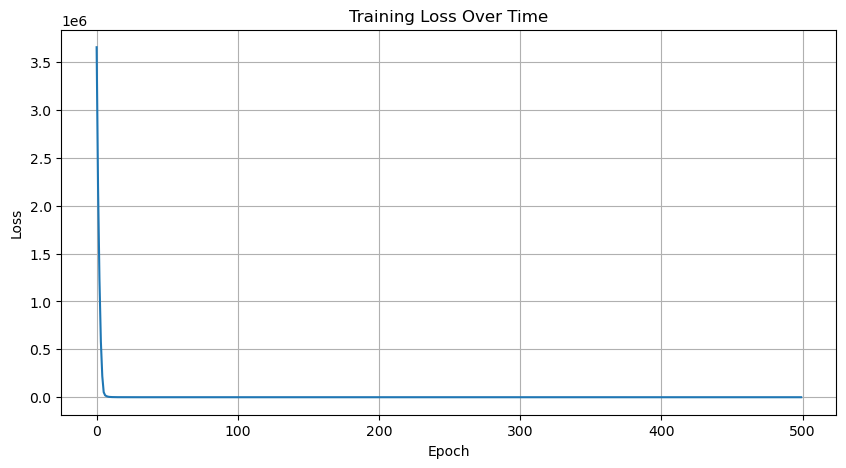

In [7]:
# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training parameters
max_epochs = 500
loss_history = []

print("Starting training...")
print(f"Forward constraint 1: (x,y,0) -> (x,0,0)")
print(f"Forward constraint 2: (x,0,1) -> (x,1,1)")
print(f"Using {num_iterations} iterations with {activation} activation")
print(f"Loss calculation only uses the first 3 dimensions (x, y, z)")

for epoch in range(max_epochs):
    epoch_loss = 0
    num_batches = 0
    
    for batch_idx, (input_batch, target_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass through the network multiple times (iterative)
        current_output = input_batch
        total_loss = 0
        
        for iteration in range(num_iterations):
            # Apply activation only on non-final iterations
            apply_activation = (iteration < num_iterations - 1)
            current_output = net(current_output, apply_activation)
            
            # Forward loss 1: (x,y,0) -> (x,0,0)
            # Only consider the first 3 entries (x, y, z)
            forward_loss = criterion(current_output[:, :3], target_batch[:, :3]) 

            # Weight the losses by iteration
            total_loss += (forward_loss) * (iteration + 1)

        # Backward pass
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += total_loss.item()
        num_batches += 1
    
    # Record average loss for this epoch
    avg_loss = epoch_loss / num_batches
    loss_history.append(avg_loss)
    
    # Print progress
    if epoch % 25 == 0:
        print(f"Epoch {epoch}/{max_epochs}, Loss: {avg_loss:.6f}")

print("Training completed!")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## Testing and Visualization

Test the trained network on both forward and inverse transformations.

Forward transformation MSE: 0.079230
Using 5 iterations with tanhshrink activation


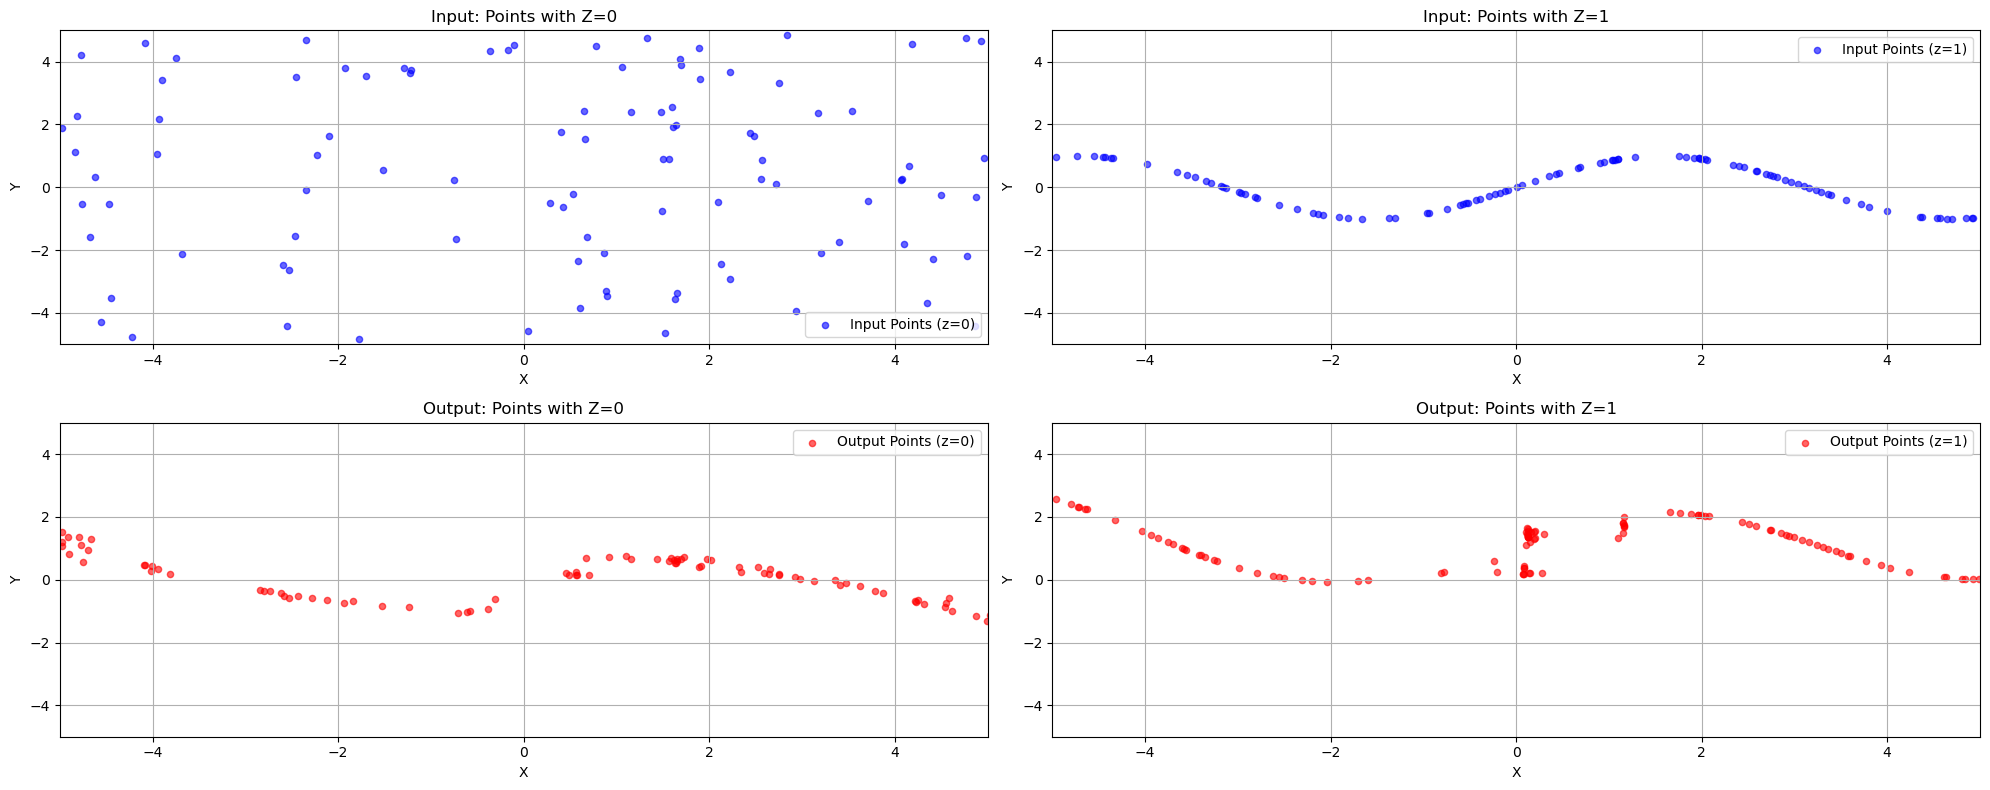

Y-coordinate statistics after transformation:
  Mean: 0.608379
  Std: 0.896540
  Min: -1.385818
  Max: 2.766828


In [8]:
# Test forward transformation: 2D points -> x-axis
net.eval()
with torch.no_grad():
    # Generate test points
    test_input, test_target = generate_3d_data(200, hidden_size)
    test_input_tensor = torch.tensor(test_input, dtype=torch.float32).to(device)
    test_target_tensor = torch.tensor(test_target, dtype=torch.float32).to(device)
    
    # Forward pass through network
    test_output = test_input_tensor
    for iteration in range(num_iterations):
        apply_activation = (iteration < num_iterations - 1)
        test_output = net(test_output, apply_activation)
    
    # Move to CPU for visualization
    test_input_cpu = test_input_tensor.cpu().numpy()
    test_output_cpu = test_output.cpu().numpy()
    test_target_cpu = test_target_tensor.cpu().numpy()
    
    # Calculate errors - only on the first 3 entries (x, y, z)
    forward_mse = mean_squared_error(test_target_cpu[:, :3], test_output_cpu[:, :3])
    print(f"Forward transformation MSE: {forward_mse:.6f}")
    print(f"Using {num_iterations} iterations with {activation} activation")
    
    # Visualization - split by z-coordinate
    plt.figure(figsize=(20, 8))
    
    # Split test data by z-coordinate
    test_input_z0_mask = test_input_cpu[:, 2] == 0
    test_input_z1_mask = test_input_cpu[:, 2] == 1
    test_output_z0_mask = test_output_cpu[:, 2] <= 0.5
    test_output_z1_mask = test_output_cpu[:, 2] > 0.5
    
    # Plot 1: Input data with z=0
    plt.subplot(2, 2, 1)
    plt.scatter(test_input_cpu[test_input_z0_mask, 0], test_input_cpu[test_input_z0_mask, 1], alpha=0.6, c='blue', s=20, label='Input Points (z=0)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Input: Points with Z=0')
    plt.legend()
    plt.grid(True)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    # Plot 2: Input data with z=1
    plt.subplot(2, 2, 2)
    plt.scatter(test_input_cpu[test_input_z1_mask, 0], test_input_cpu[test_input_z1_mask, 1], alpha=0.6, c='blue', s=20, label='Input Points (z=1)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Input: Points with Z=1')
    plt.legend()
    plt.grid(True)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    # Plot 3: Network output with z=0
    plt.subplot(2, 2, 3)
    plt.scatter(test_output_cpu[test_output_z0_mask, 0], test_output_cpu[test_output_z0_mask, 1], alpha=0.6, c='red', s=20, label='Output Points (z=0)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Output: Points with Z=0')
    plt.legend()
    plt.grid(True)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    # Plot 4: Network output with z=1
    plt.subplot(2, 2, 4)
    plt.scatter(test_output_cpu[test_output_z1_mask, 0], test_output_cpu[test_output_z1_mask, 1], alpha=0.6, c='red', s=20, label='Output Points (z=1)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Output: Points with Z=1')
    plt.legend()
    plt.grid(True)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    
    plt.tight_layout()
    plt.show()
    
    # Check how close y-values are to 0
    y_values = test_output_cpu[:, 1]
    print(f"Y-coordinate statistics after transformation:")
    print(f"  Mean: {np.mean(y_values):.6f}")
    print(f"  Std: {np.std(y_values):.6f}")
    print(f"  Min: {np.min(y_values):.6f}")
    print(f"  Max: {np.max(y_values):.6f}")

Testing with 5 iterations and tanhshrink activation
MSE calculations only use the first 3 dimensions (x, y, z)


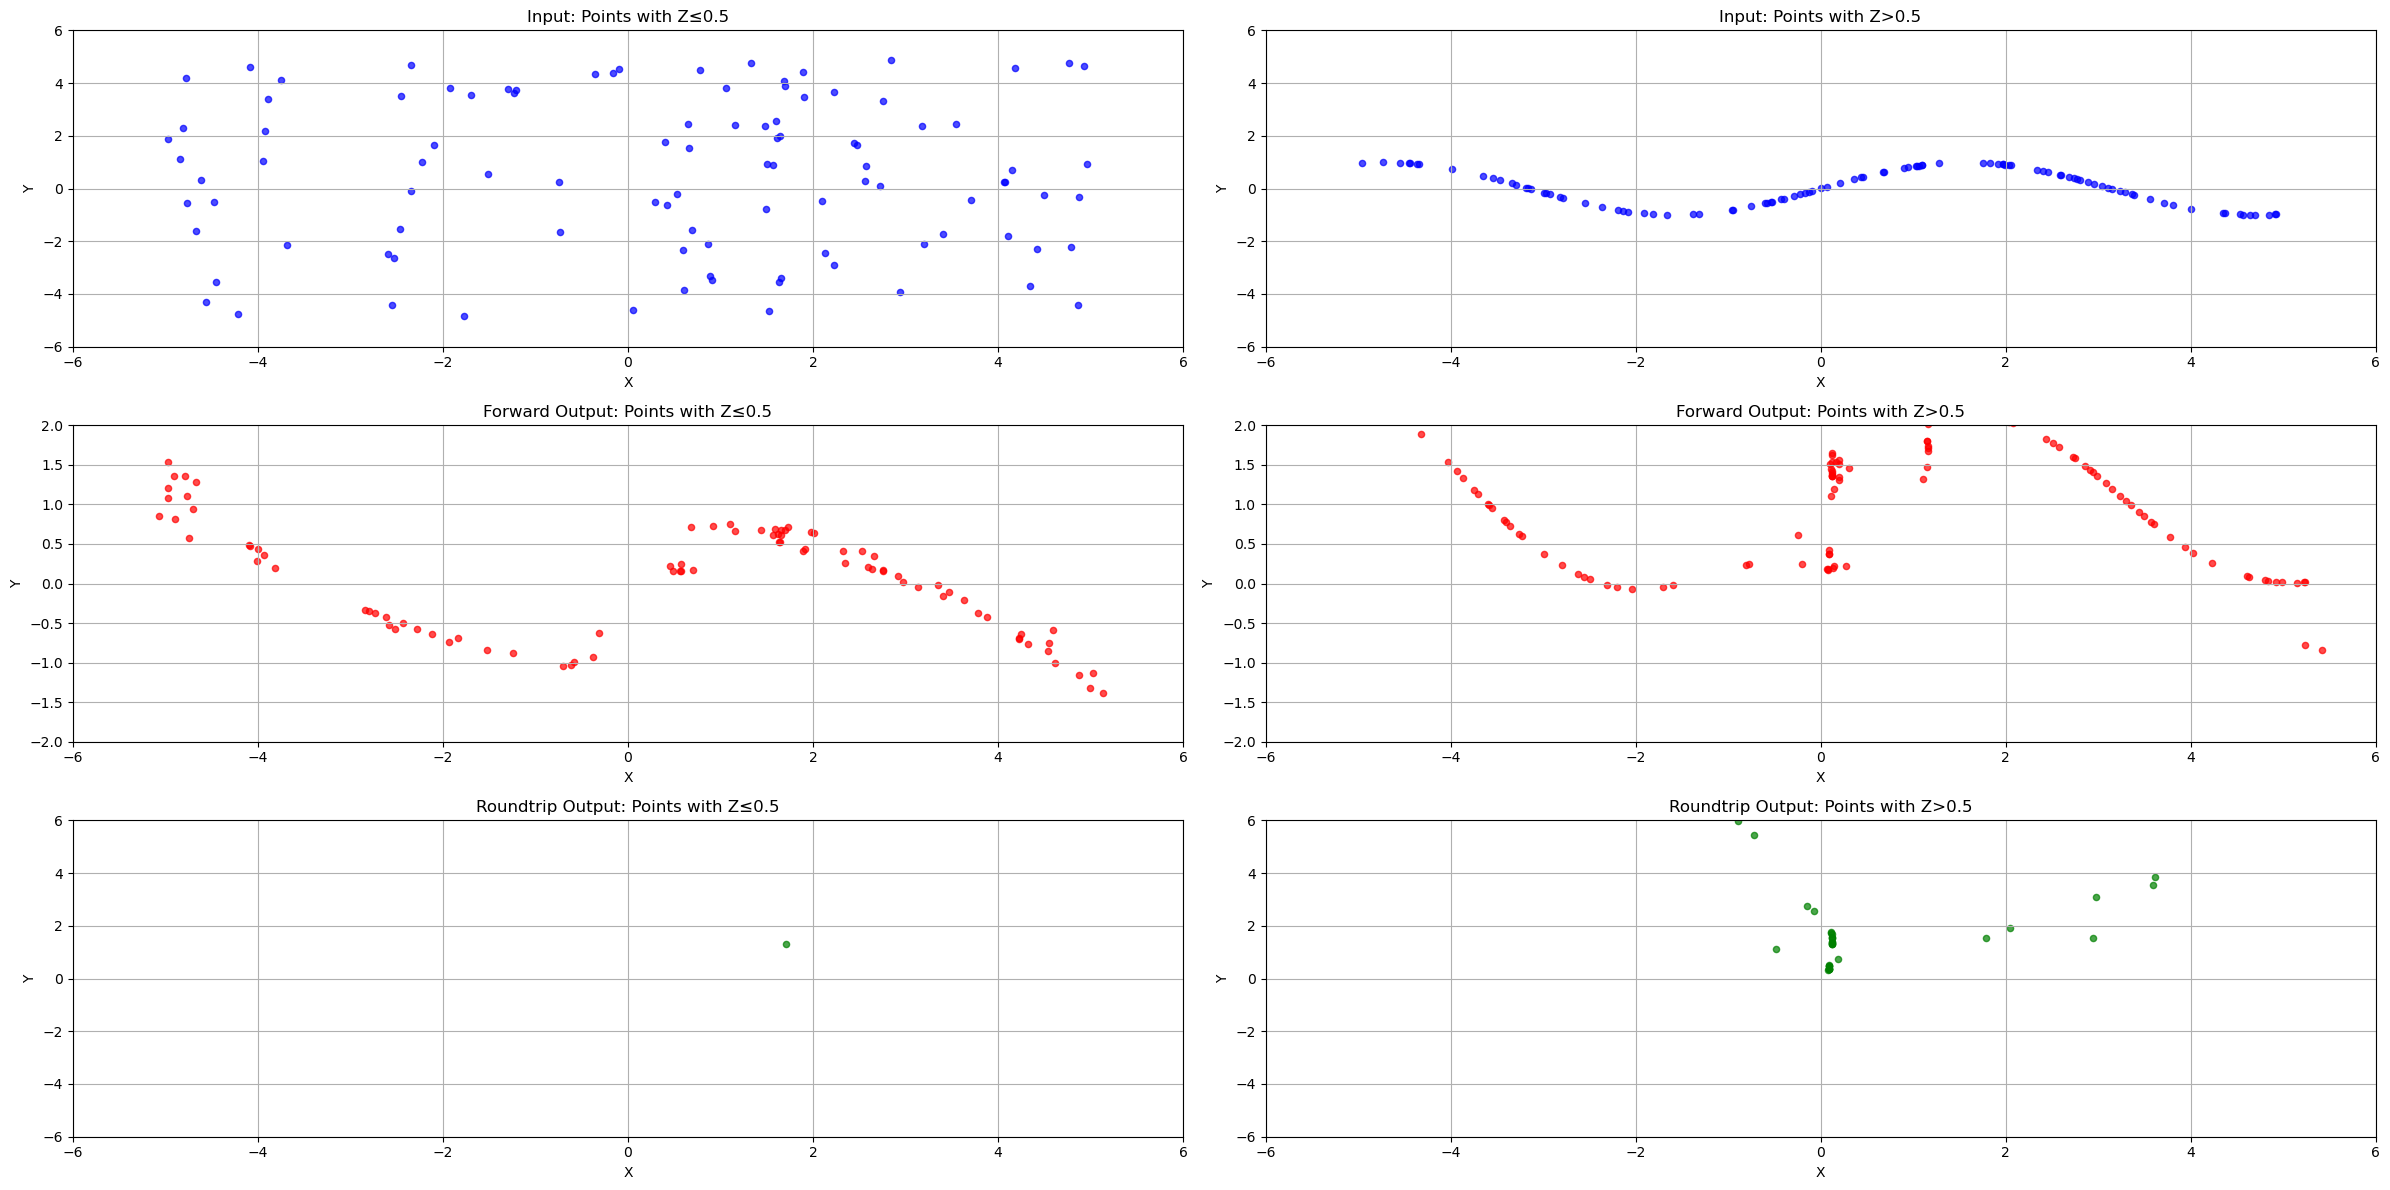

Transformation Analysis:
Forward transformation MSE: 0.079230
Inverse transformation MSE: 0.110171
Roundtrip transformation MSE: 4766.187012

Roundtrip Y-coordinate statistics:
  Original mean: 0.291361
  Roundtrip mean: 32.089355
  Difference: 76.214821


In [9]:
# Test the inverse transformation: (x,0,1) -> (x,1,1) and roundtrip
net.eval()
with torch.no_grad():
    # Create test data for inverse transformation
    # Input: (x, 0, 1) should map to (x, 1, 1)
    x_values = np.linspace(-3, 3, 50)
    
    # Create base columns
    inverse_input_cols = [x_values, np.zeros(50), np.ones(50)]
    inverse_target_cols = [x_values, np.ones(50), np.ones(50)]
    
    # Add hidden dimensions
    for _ in range(hidden_size):
        inverse_input_cols.append(np.zeros(50))
        inverse_target_cols.append(np.zeros(50))
    
    inverse_input = np.column_stack(inverse_input_cols) #modify length here
    inverse_target = np.column_stack(inverse_target_cols) #modify length here

    # Convert to tensors
    inverse_input_tensor = torch.tensor(inverse_input, dtype=torch.float32).to(device)
    inverse_target_tensor = torch.tensor(inverse_target, dtype=torch.float32).to(device)
    
    # Forward pass for inverse transformation
    inverse_output = inverse_input_tensor
    for iteration in range(num_iterations):
        apply_activation = (iteration < num_iterations - 1)
        inverse_output = net(inverse_output, apply_activation)
    
    # Now test roundtrip: take forward output and set z=1, then apply network again
    forward_output_modified = test_output.clone()
    forward_output_modified[:, 2] = 1.0  # Set z-coordinate to 1
    
    # Apply network again for roundtrip
    roundtrip_output = forward_output_modified
    for iteration in range(num_iterations):
        apply_activation = (iteration < num_iterations - 1)
        roundtrip_output = net(roundtrip_output, apply_activation)
    
    # Move to CPU for calculations
    inverse_input_cpu = inverse_input_tensor.cpu().numpy()
    inverse_output_cpu = inverse_output.cpu().numpy()
    roundtrip_output_cpu = roundtrip_output.cpu().numpy()
    
    # Calculate errors - only on the first 3 entries (x, y, z)
    inverse_mse = mean_squared_error(inverse_target_tensor.cpu().numpy()[:, :3], inverse_output_cpu[:, :3])
    # Calculate the expected roundtrip result: sin(test_input)+1
    expected_roundtrip = test_input_cpu[:, :3].copy()
    expected_roundtrip[:, 1] = np.sin(test_input_cpu[:, 0]) + 1  # Only transform y coordinate
    roundtrip_mse = mean_squared_error(expected_roundtrip, roundtrip_output_cpu[:, :3])
    
    print(f"Testing with {num_iterations} iterations and {activation} activation")
    print(f"MSE calculations only use the first 3 dimensions (x, y, z)")
    
    # Create visualization - 6 graphs in 2x3 layout
    plt.figure(figsize=(24, 12))
    
    # Split data by z-coordinate using thresholds (network may change z values)
    test_input_z0_mask = test_input_cpu[:, 2] <= 0.5
    test_input_z1_mask = test_input_cpu[:, 2] > 0.5
    test_output_z0_mask = test_output_cpu[:, 2] <= 0.5
    test_output_z1_mask = test_output_cpu[:, 2] > 0.5
    roundtrip_output_z0_mask = roundtrip_output_cpu[:, 2] <= 0.5
    roundtrip_output_z1_mask = roundtrip_output_cpu[:, 2] > 0.5
    
    # Row 1: Input data
    # Plot 1: Input data with z<=0.5
    plt.subplot(3, 2, 1)
    plt.scatter(test_input_cpu[test_input_z0_mask, 0], test_input_cpu[test_input_z0_mask, 1], alpha=0.7, c='blue', s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Input: Points with Z≤0.5')
    plt.grid(True)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    
    # Plot 2: Input data with z>0.5
    plt.subplot(3, 2, 2)
    plt.scatter(test_input_cpu[test_input_z1_mask, 0], test_input_cpu[test_input_z1_mask, 1], alpha=0.7, c='blue', s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Input: Points with Z>0.5')
    plt.grid(True)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    
    # Row 2: Forward transformation result
    # Plot 3: Forward output with z<=0.5
    plt.subplot(3, 2, 3)
    plt.scatter(test_output_cpu[test_output_z0_mask, 0], test_output_cpu[test_output_z0_mask, 1], alpha=0.7, c='red', s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Forward Output: Points with Z≤0.5')
    plt.grid(True)
    plt.xlim(-6, 6)
    plt.ylim(-2, 2)
    
    # Plot 4: Forward output with z>0.5
    plt.subplot(3, 2, 4)
    plt.scatter(test_output_cpu[test_output_z1_mask, 0], test_output_cpu[test_output_z1_mask, 1], alpha=0.7, c='red', s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Forward Output: Points with Z>0.5')
    plt.grid(True)
    plt.xlim(-6, 6)
    plt.ylim(-2, 2)
    
    # Row 3: Roundtrip transformation result
    # Plot 5: Roundtrip output with z<=0.5
    plt.subplot(3, 2, 5)
    plt.scatter(roundtrip_output_cpu[roundtrip_output_z0_mask, 0], roundtrip_output_cpu[roundtrip_output_z0_mask, 1], alpha=0.7, c='green', s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Roundtrip Output: Points with Z≤0.5')
    plt.grid(True)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    
    # Plot 6: Roundtrip output with z>0.5
    plt.subplot(3, 2, 6)
    plt.scatter(roundtrip_output_cpu[roundtrip_output_z1_mask, 0], roundtrip_output_cpu[roundtrip_output_z1_mask, 1], alpha=0.7, c='green', s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Roundtrip Output: Points with Z>0.5')
    plt.grid(True)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("Transformation Analysis:")
    print("="*50)
    print(f"Forward transformation MSE: {forward_mse:.6f}")
    print(f"Inverse transformation MSE: {inverse_mse:.6f}")
    print(f"Roundtrip transformation MSE: {roundtrip_mse:.6f}")
    
    print(f"\nRoundtrip Y-coordinate statistics:")
    print(f"  Original mean: {np.mean(test_input_cpu[:, 1]):.6f}")
    print(f"  Roundtrip mean: {np.mean(roundtrip_output_cpu[:, 1]):.6f}")
    print(f"  Difference: {np.mean(np.abs(test_input_cpu[:, 1] - roundtrip_output_cpu[:, 1])):.6f}")
# Jump Here for spreadsheet numbers

Running convex combination test with 5 iterations and tanhshrink activation
Starting Comprehensive Convex Combination Test
Step 1: Generating random points...
Generated 200 random points
Step 2: Applying trained model transformation m(x, y, 0) → (x, sin(x), 0)...
Applied trained model transformation
Step 3: Applying trained model transformation m(x, sin(x), 1) → (x, sin(x)+1, 1)...
Applied trained model inverse transformation
Step 4: Creating convex combinations...
Created 100 convex combination points
Step 5: Applying trained model to convex combinations...
Applied trained model to convex combinations
Final transformation MSE (first 3 dims): 2029001.000000


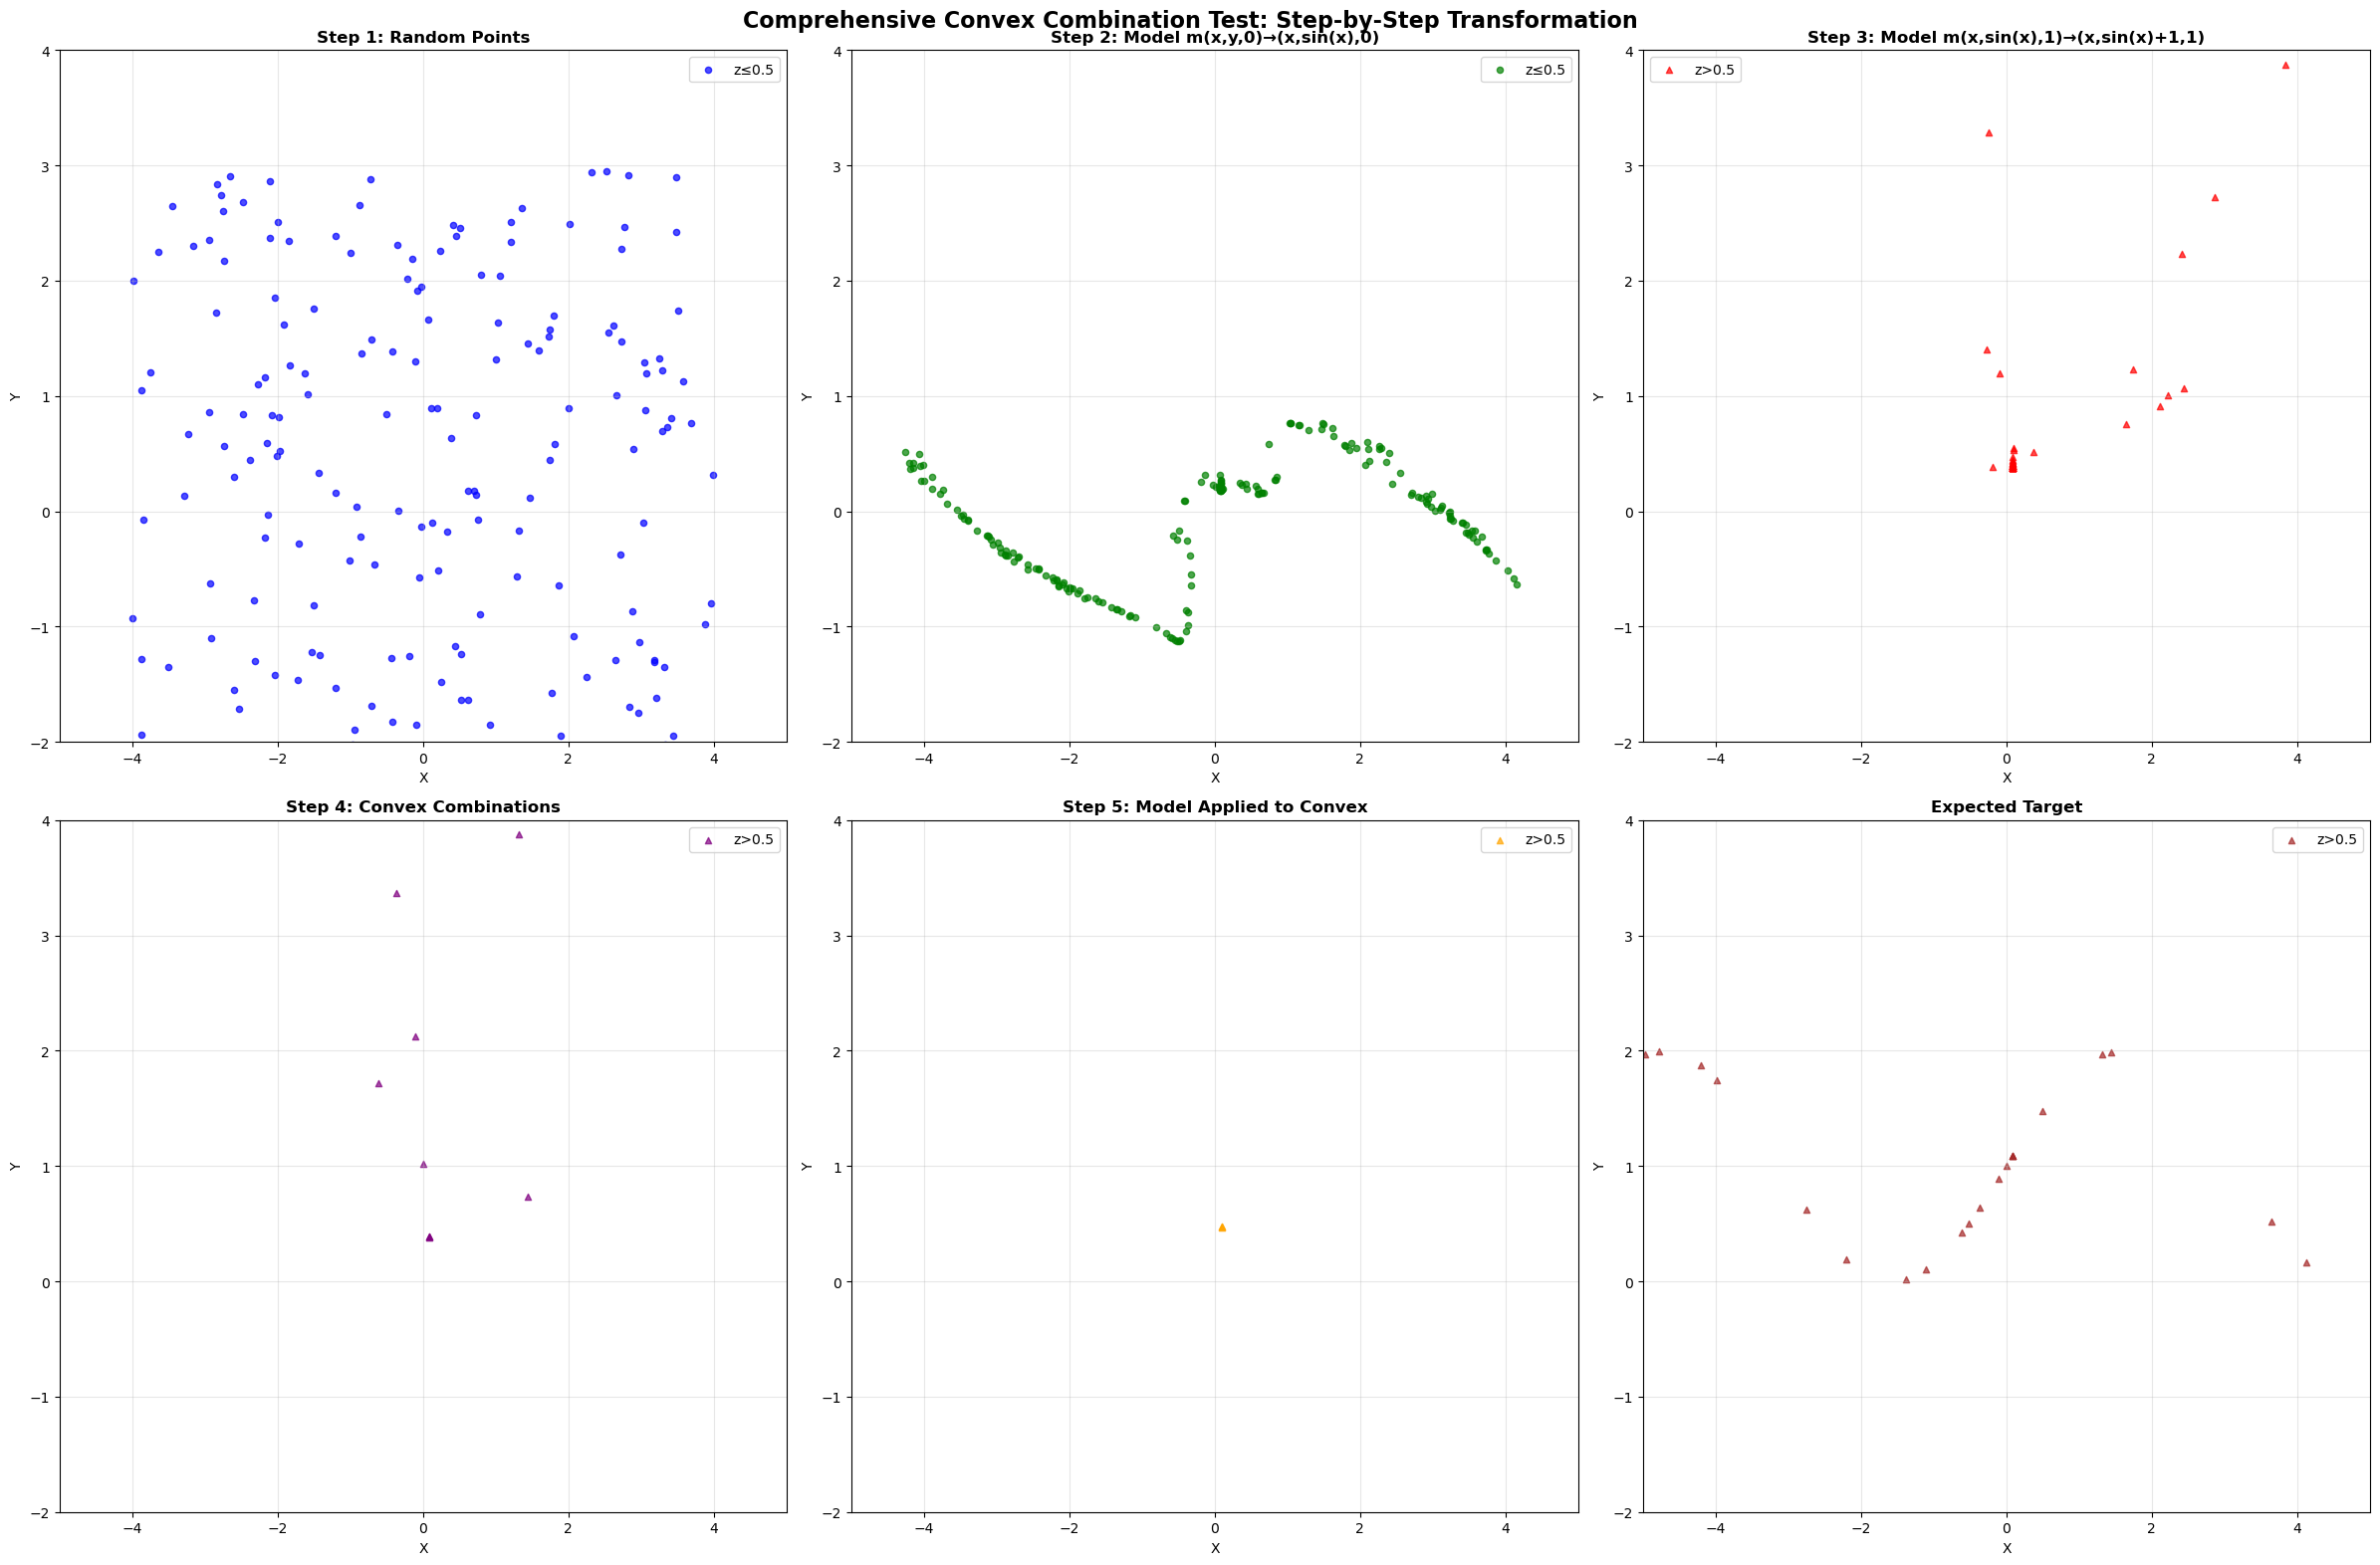

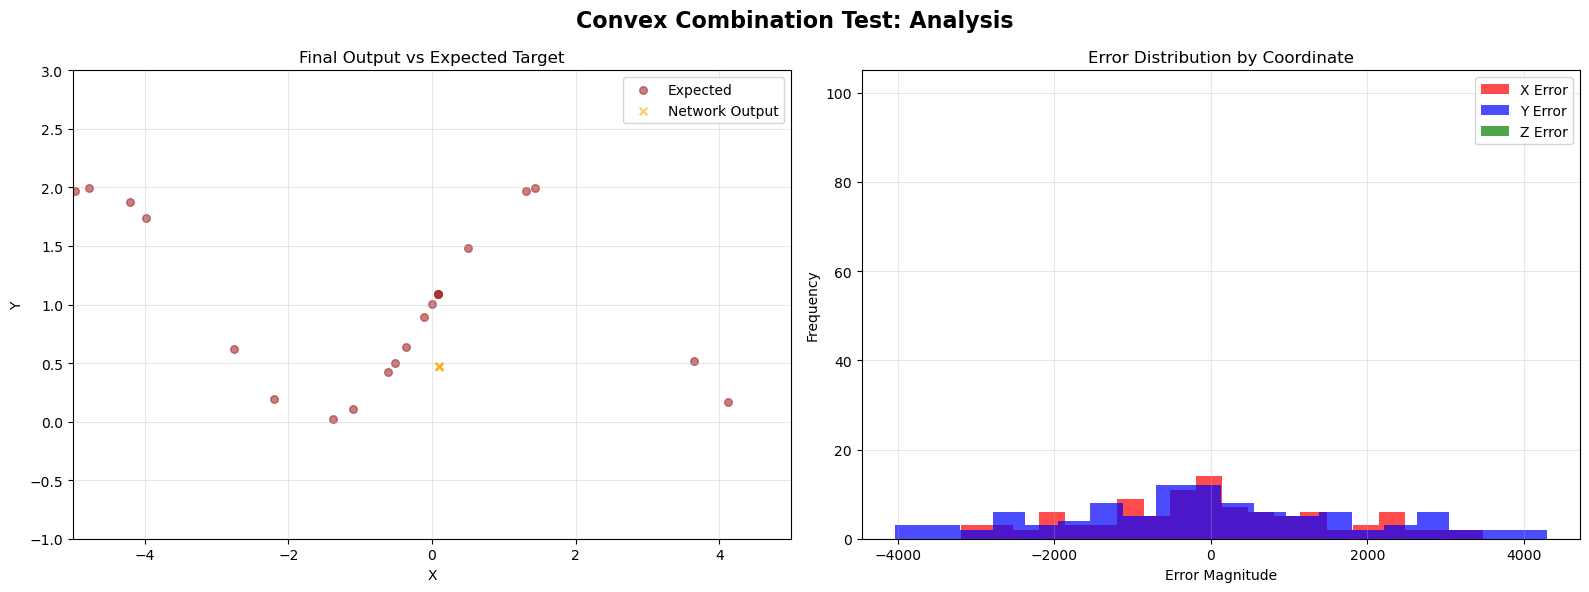


CONVEX COMBINATION TEST ANALYSIS
Test Configuration:
  Number of initial random points: 200
  Number of convex combination points: 100
  Final transformation MSE: 2029001.000000
  Network iterations: 5
  Activation function: tanhshrink

Step-by-Step Y-Coordinate Analysis:
Step 1: Random Points:
  Y mean: 0.1408, std: 1.7334
Step 2: Model Transform m(x,y,0):
  Y mean: -0.0859, std: 0.4849
Step 3: Model Inverse m(x,sin(x),1):
  Y mean: 16.6482, std: 67.7613
Step 4: Convex Combinations:
  Y mean: 15.7423, std: 53.5077
Step 5: Model Applied to Convex:
  Y mean: -60.2388, std: 1924.5695

Final Error Analysis (first 3 dimensions only):
  X-coordinate:
    Mean Absolute Error: 1204.580200
    Root Mean Square Error: 1542.420654
  Y-coordinate:
    Mean Absolute Error: 1512.621704
    Root Mean Square Error: 1925.601440
  Z-coordinate:
    Mean Absolute Error: 0.000000
    Root Mean Square Error: 0.000000

Convex combination test: NEEDS IMPROVEMENT
(Success threshold: MSE < 0.01)


In [10]:
# Comprehensive Convex Combination Test
# Process: random points → sine wave → inverse (sin + 1) → convex combinations → forward map
def comprehensive_convex_test(net, n_samples=200, x_range=(-4, 4)):
    """
    Comprehensive test using the trained model at each step:
    1. Generate random points (x, y, 0)
    2. Apply trained model: m(x, y, 0) → (x, sin(x), 0) 
    3. Apply trained model: m(x, sin(x), 1) → (x, sin(x)+1, 1)
    4. Create convex combinations of model outputs
    5. Apply trained model to convex combinations
    """
    print("Starting Comprehensive Convex Combination Test")
    print("="*60)
    
    # Step 1: Generate random points
    print("Step 1: Generating random points...")
    x_random = np.random.uniform(x_range[0], x_range[1], n_samples)
    y_random = np.random.uniform(-3, 3, n_samples)  # Random y values
    z_random = np.zeros(n_samples)  # Start with z=0
    
    # Add hidden dimensions
    step1_cols = [x_random, y_random, z_random]
    for _ in range(hidden_size):
        step1_cols.append(np.zeros(n_samples))
    
    step1_points = np.column_stack(step1_cols)
    print(f"Generated {n_samples} random points")
    
    # Step 2: Apply trained model transformation m(x, y, 0) → (x, sin(x), 0)
    print("Step 2: Applying trained model transformation m(x, y, 0) → (x, sin(x), 0)...")
    step1_tensor = torch.tensor(step1_points, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        step2_output = step1_tensor
        for iteration in range(num_iterations):
            apply_activation = (iteration < num_iterations - 1)
            step2_output = net(step2_output, apply_activation)
    
    step2_points = step2_output.cpu().numpy()
    # Ensure z-coordinate remains 0 for forward transformation
    step2_points[:, 2] = 0.0
    print("Applied trained model transformation")
    
    # Step 3: Modify z-coordinate and apply model again: m(x, sin(x), 1) → (x, sin(x)+1, 1)
    print("Step 3: Applying trained model transformation m(x, sin(x), 1) → (x, sin(x)+1, 1)...")
    # Take step2 output and change z-coordinate to 1
    step2_modified = step2_points.copy()
    step2_modified[:, 2] = 1.0  # Set z=1 for inverse mapping
    
    step2_modified_tensor = torch.tensor(step2_modified, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        step3_output = step2_modified_tensor
        for iteration in range(num_iterations):
            apply_activation = (iteration < num_iterations - 1)
            step3_output = net(step3_output, apply_activation)
    
    step3_points = step3_output.cpu().numpy()
    # Ensure z-coordinate remains 1 for inverse transformation
    step3_points[:, 2] = 1.0
    print("Applied trained model inverse transformation")
    
    # Step 4: Create convex combinations
    print("Step 4: Creating convex combinations...")
    # Randomly pair points for convex combinations
    indices = np.random.permutation(n_samples)
    pairs = indices.reshape(-1, 2)[:n_samples//2]  # Create pairs
    
    convex_points = []
    for i, (idx1, idx2) in enumerate(pairs):
        # Random convex combination weights
        alpha = np.random.uniform(0, 1)
        
        # Create convex combination
        point1 = step3_points[idx1]
        point2 = step3_points[idx2]
        convex_point = alpha * point1 + (1 - alpha) * point2
        convex_points.append(convex_point)
    
    step4_points = np.array(convex_points)
    # Ensure z-coordinate is exactly 1 for convex combinations (since they come from step3 with z=1)
    step4_points[:, 2] = 1.0
    print(f"Created {len(step4_points)} convex combination points")
    
    # Step 5: Apply trained model to convex combinations
    print("Step 5: Applying trained model to convex combinations...")
    net.eval()
    with torch.no_grad():
        # Convert to tensor
        step4_tensor = torch.tensor(step4_points, dtype=torch.float32).to(device)
        
        # Generate target for comparison (what we expect the model to output)
        expected_target = step4_points.copy()
        # Since step4_points have z=1, the model should apply m(x, y, 1) → (x, sin(x)+1, 1)
        # But since these are convex combinations of points already at (x, sin(x)+1, 1),
        # we expect the model to maintain the transformation: (x, y, 1) → (x, sin(x)+1, 1)
        expected_target[:, 1] = np.sin(expected_target[:, 0]) + 1
        
        # Apply trained model iteratively
        step5_output = step4_tensor
        for iteration in range(num_iterations):
            apply_activation = (iteration < num_iterations - 1)
            step5_output = net(step5_output, apply_activation)
        
    step5_points = step5_output.cpu().numpy()
    # Ensure z-coordinate remains 1 after applying model to convex combinations
    step5_points[:, 2] = 1.0
    print("Applied trained model to convex combinations")
    
    # Calculate MSE - only on first 3 dimensions
    mse = mean_squared_error(expected_target[:, :3], step5_points[:, :3])
    print(f"Final transformation MSE (first 3 dims): {mse:.6f}")
    
    return {
        'step1_random': step1_points,
        'step2_model_transform': step2_points, 
        'step3_model_inverse': step3_points,
        'step4_convex': step4_points,
        'step5_model_final': step5_points,
        'expected_target': expected_target,
        'mse': mse
    }

# Visualization function for all steps
def visualize_convex_test(results):
    """Create comprehensive visualization of all transformation steps"""
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle('Comprehensive Convex Combination Test: Step-by-Step Transformation', fontsize=16, fontweight='bold')
    
    steps = [
        ('step1_random', 'Step 1: Random Points', 'blue'),
        ('step2_model_transform', 'Step 2: Model m(x,y,0)→(x,sin(x),0)', 'green'), 
        ('step3_model_inverse', 'Step 3: Model m(x,sin(x),1)→(x,sin(x)+1,1)', 'red'),
        ('step4_convex', 'Step 4: Convex Combinations', 'purple'),
        ('step5_model_final', 'Step 5: Model Applied to Convex', 'orange'),
        ('expected_target', 'Expected Target', 'brown')
    ]
    
    for i, (key, title, color) in enumerate(steps):
        ax = axes[i // 3, i % 3]
        points = results[key]
        
        # Split by z-coordinate for better visualization
        if len(points) > 0:
            z_mask_0 = points[:, 2] <= 0.5
            z_mask_1 = points[:, 2] > 0.5
            
            if np.any(z_mask_0):
                ax.scatter(points[z_mask_0, 0], points[z_mask_0, 1], 
                          alpha=0.7, c=color, s=20, label=f'z≤0.5', marker='o')
            
            if np.any(z_mask_1):
                ax.scatter(points[z_mask_1, 0], points[z_mask_1, 1], 
                          alpha=0.7, c=color, s=20, label=f'z>0.5', marker='^')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y') 
        ax.set_title(title, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-5, 5)
        ax.set_ylim(-2, 4)
    
    plt.tight_layout()
    plt.show()
    
    # Error analysis plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Convex Combination Test: Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Final vs Expected comparison
    ax1 = axes[0]
    final_points = results['step5_model_final']
    expected_points = results['expected_target']
    
    ax1.scatter(expected_points[:, 0], expected_points[:, 1], alpha=0.6, c='brown', s=30, label='Expected', marker='o')
    ax1.scatter(final_points[:, 0], final_points[:, 1], alpha=0.6, c='orange', s=30, label='Network Output', marker='x')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('Final Output vs Expected Target')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-1, 3)
    
    # Plot 2: Error distribution
    ax2 = axes[1]
    errors = final_points[:, :3] - expected_points[:, :3]
    
    ax2.hist(errors[:, 0], bins=20, alpha=0.7, label='X Error', color='red')
    ax2.hist(errors[:, 1], bins=20, alpha=0.7, label='Y Error', color='blue') 
    ax2.hist(errors[:, 2], bins=20, alpha=0.7, label='Z Error', color='green')
    ax2.set_xlabel('Error Magnitude')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Error Distribution by Coordinate')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run the comprehensive convex combination test
print(f"Running convex combination test with {num_iterations} iterations and {activation} activation")
test_results = comprehensive_convex_test(net, n_samples=200)

# Visualize the results
visualize_convex_test(test_results)

# Statistical analysis
print("\n" + "="*60)
print("CONVEX COMBINATION TEST ANALYSIS")
print("="*60)

print(f"Test Configuration:")
print(f"  Number of initial random points: {len(test_results['step1_random'])}")
print(f"  Number of convex combination points: {len(test_results['step4_convex'])}")
print(f"  Final transformation MSE: {test_results['mse']:.6f}")
print(f"  Network iterations: {num_iterations}")
print(f"  Activation function: {activation}")

# Step-by-step coordinate analysis
steps = [
    ('step1_random', 'Step 1: Random Points'),
    ('step2_model_transform', 'Step 2: Model Transform m(x,y,0)'),
    ('step3_model_inverse', 'Step 3: Model Inverse m(x,sin(x),1)'),
    ('step4_convex', 'Step 4: Convex Combinations'),
    ('step5_model_final', 'Step 5: Model Applied to Convex')
]

print(f"\nStep-by-Step Y-Coordinate Analysis:")
for key, name in steps:
    points = test_results[key]
    y_values = points[:, 1]
    print(f"{name}:")
    print(f"  Y mean: {np.mean(y_values):.4f}, std: {np.std(y_values):.4f}")

# Final comparison
final_output = test_results['step5_model_final']
expected_target = test_results['expected_target']
errors = final_output[:, :3] - expected_target[:, :3]

print(f"\nFinal Error Analysis (first 3 dimensions only):")
for i, coord in enumerate(['X', 'Y', 'Z']):
    coord_errors = errors[:, i]
    print(f"  {coord}-coordinate:")
    print(f"    Mean Absolute Error: {np.mean(np.abs(coord_errors)):.6f}")
    print(f"    Root Mean Square Error: {np.sqrt(np.mean(coord_errors**2)):.6f}")

success_threshold = 0.01
overall_success = test_results['mse'] < success_threshold
print(f"\nConvex combination test: {'SUCCESS' if overall_success else 'NEEDS IMPROVEMENT'}")
print(f"(Success threshold: MSE < {success_threshold})")

print("="*60)

## Results Summary

Evaluate the overall performance of the masked linear iterative neural network.

In [11]:
# Complete evaluation of the network
print("="*60)
print("MASKED LINEAR ITERATIVE NEURAL NETWORK EVALUATION")
print("="*60)

# Network parameters
total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Network Configuration:")
print(f"  Hidden size: {hidden_size}")
print(f"  Number of iterations: {num_iterations}")
print(f"  Activation function: {activation}")
print(f"  Input dimensions: {input_size} (3 base + {hidden_size} hidden)")
print(f"  Output dimensions: {output_size} (3 base + {hidden_size} hidden)")
print(f"  Row sizes: {row_sizes}")
print(f"  Column sizes: {col_sizes}")
print(f"  Total parameters: {total_params}")
print(f"  Trainable parameters: {trainable_params}")
print(f"  MSE calculations: Only on first 3 dimensions (x, y, z)")

print(f"\nTraining Results:")
print(f"  Final training loss: {loss_history[-1]:.6f}")
print(f"  Training epochs: {max_epochs}")

print(f"\nForward Transformation Performance:")
print(f"  Task: Map (x,y) -> (x,0)")
print(f"  Test MSE (first 3 dims only): {forward_mse:.6f}")
print(f"  Y-coordinate mean: {np.mean(y_values):.6f} (target: 0)")
print(f"  Y-coordinate std: {np.std(y_values):.6f}")

print(f"\nInverse Transformation Performance:")
print(f"  Task: Map (x,0) -> (x,1)")
print(f"  Test MSE (first 3 dims only): {inverse_mse:.6f}")
# Extract y-values from inverse output for analysis
y_values_inverse = inverse_output_cpu[:, 1]
print(f"  Y-coordinate mean: {np.mean(y_values_inverse):.6f} (target: 1)")
print(f"  Y-coordinate std: {np.std(y_values_inverse):.6f}")

# Calculate how well x-coordinates are preserved in the transformation
x_diff = np.abs(inverse_input_cpu[:, 0] - inverse_output_cpu[:, 0])
print(f"  X-coordinate preservation error: {np.mean(x_diff):.6f}")

print(f"\nRoundtrip Transformation Performance:")
print(f"  Test MSE (first 3 dims only): {roundtrip_mse:.6f}")

# Visualize network weights
print(f"\nNetwork Weight Analysis:")
with torch.no_grad():
    current_weight = masked_linear.weight_0 + masked_linear.U * masked_linear.mask
    print(f"  Current weight matrix:")
    print(f"    Shape: {current_weight.shape}")
    print(f"    Matrix:\n{current_weight.cpu().numpy()}")
    
    if masked_linear.bias is not None:
        print(f"  Bias vector: {masked_linear.bias.cpu().numpy()}")

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)

success_threshold = 0.01
forward_success = forward_mse < success_threshold
inverse_success = inverse_mse < success_threshold

print(f"Forward transformation: {'SUCCESS' if forward_success else 'NEEDS IMPROVEMENT'}")
print(f"Inverse transformation: {'SUCCESS' if inverse_success else 'NEEDS IMPROVEMENT'}")
print(f"Overall network: {'SUCCESS' if forward_success and inverse_success else 'NEEDS IMPROVEMENT'}")

if forward_success and inverse_success:
    print("\nThe masked linear iterative neural network successfully learned:")
    print("1. To map 2D points to the x-axis (y ≈ 0)")
    print("2. To ensure the inverse maps x-axis points to y=1 line")
    print("3. To preserve x-coordinates throughout both transformations")
else:
    print("\nSuggestions for improvement:")
    if not forward_success:
        print(f"- Increase training epochs or adjust learning rate")
        print(f"- Try a different activation function (current: {activation})")
        print(f"- Modify the mask structure for better forward mapping")
    if not inverse_success:
        print(f"- Increase the weight of inverse loss in training")
        print(f"- Adjust the number of iterations (current: {num_iterations})")
        print(f"- Consider different initialization strategies")

MASKED LINEAR ITERATIVE NEURAL NETWORK EVALUATION
Network Configuration:
  Hidden size: 5
  Number of iterations: 5
  Activation function: tanhshrink
  Input dimensions: 8 (3 base + 5 hidden)
  Output dimensions: 8 (3 base + 5 hidden)
  Row sizes: [2, 1, 5]
  Column sizes: [2, 1, 5]
  Total parameters: 200
  Trainable parameters: 72
  MSE calculations: Only on first 3 dimensions (x, y, z)

Training Results:
  Final training loss: 2.125250
  Training epochs: 500

Forward Transformation Performance:
  Task: Map (x,y) -> (x,0)
  Test MSE (first 3 dims only): 0.079230
  Y-coordinate mean: -60.238773 (target: 0)
  Y-coordinate std: 1924.569458

Inverse Transformation Performance:
  Task: Map (x,0) -> (x,1)
  Test MSE (first 3 dims only): 0.110171
  Y-coordinate mean: 1.145253 (target: 1)
  Y-coordinate std: 0.275053
  X-coordinate preservation error: 0.282657

Roundtrip Transformation Performance:
  Test MSE (first 3 dims only): 4766.187012

Network Weight Analysis:
  Current weight matrix:

# Hyperparameter Tuning

In [12]:
# Hyperparameter Tuning
import csv
import time
from datetime import datetime

def run_hyperparameter_tuning():
    # Define parameter ranges
    hidden_sizes = [1, 3, 5, 7, 9, 11]
    activations = ['tanhshrink', 'tanh', 'relu', 'leaky_relu', 'sigmoid']
    num_iterations_list = [1, 3, 5, 7, 9, 11]
    
    # Number of runs per configuration
    num_runs = 3
    
    # Create CSV file with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f"../results/hyperparameter_results_{timestamp}.csv"
    
    # CSV header
    fieldnames = ['hidden_size', 'activation', 'num_iterations', 'run', 
                  'forward_mse', 'inverse_mse', 'roundtrip_mse', 'final_loss', 'runtime_seconds']
    
    results = []
    total_configs = len(hidden_sizes) * len(activations) * len(num_iterations_list) * num_runs
    current_config = 0
    
    print(f"Starting hyperparameter tuning...")
    print(f"Total configurations to test: {total_configs}")
    print(f"Results will be saved to: {csv_filename}")
    print("="*80)
    
    for hidden_size_test in hidden_sizes:
        for activation_test in activations:
            for num_iterations_test in num_iterations_list:
                for run in range(1, num_runs + 1):
                    current_config += 1
                    start_time = time.time()
                    
                    print(f"Config {current_config}/{total_configs}: hidden_size={hidden_size_test}, "
                          f"activation={activation_test}, num_iterations={num_iterations_test}, run={run}")
                    
                    try:
                        # Set the hyperparameters for this run
                        hidden_size = hidden_size_test
                        activation = activation_test
                        num_iterations = num_iterations_test
                        
                        # Network configuration
                        input_size = 3 + hidden_size
                        output_size = 3 + hidden_size
                        row_sizes = [2, 1, hidden_size]
                        col_sizes = [2, 1, hidden_size]
                        
                        # Generate training data
                        input_data, target_data = generate_3d_data(2000, hidden_size)
                        input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)
                        target_tensor = torch.tensor(target_data, dtype=torch.float32).to(device)
                        
                        block_types = [['W','W','W'], 
                                       ['W','D','W'],
                                       ['W','W','W']]
                        initialization_types = [['G','G','G'], 
                                                ['G', 1 ,'G'],
                                                ['G','G','G']]
                        trainable = [['non-zero','non-zero','non-zero'], 
                                     ['non-zero', 0        ,'non-zero'],  
                                     ['non-zero','non-zero','non-zero']]
                        
                        # Create the MaskedLinear layer
                        ml = MaskedLinear(input_size, output_size, bias=True)
                        masked_linear = ml.from_description(row_sizes=row_sizes,
                                                            col_sizes=col_sizes,
                                                            block_types=block_types,
                                                            initialization_types=initialization_types,
                                                            trainable=trainable)
                        
                        # Create the network
                        net = ConditionalIterativeNet(masked_linear, activation).to(device)
                        
                        # Training setup
                        criterion = nn.MSELoss()
                        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
                        
                        # Create dataset and dataloader
                        train_dataset = TwoDDataset(input_tensor, target_tensor)
                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
                        
                        # Training loop (reduced epochs for faster tuning)
                        max_epochs = 100
                        loss_history = []
                        
                        for epoch in range(max_epochs):
                            epoch_loss = 0
                            num_batches = 0
                            
                            for batch_idx, (input_batch, target_batch) in enumerate(train_loader):
                                optimizer.zero_grad()
                                
                                # Forward pass through the network multiple times (iterative)
                                current_output = input_batch
                                total_loss = 0
                                
                                for iteration in range(num_iterations):
                                    apply_activation = (iteration < num_iterations - 1)
                                    current_output = net(current_output, apply_activation)
                                    
                                    forward_loss = criterion(current_output[:, :3], target_batch[:, :3]) 
                                    total_loss += (forward_loss) * (iteration + 1)
                                
                                total_loss.backward()
                                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                                optimizer.step()
                                
                                epoch_loss += total_loss.item()
                                num_batches += 1
                            
                            avg_loss = epoch_loss / num_batches
                            loss_history.append(avg_loss)
                        
                        # Testing phase
                        net.eval()
                        with torch.no_grad():
                            # Generate test points
                            test_input, test_target = generate_3d_data(200, hidden_size)
                            test_input_tensor = torch.tensor(test_input, dtype=torch.float32).to(device)
                            test_target_tensor = torch.tensor(test_target, dtype=torch.float32).to(device)
                            
                            # Forward pass through network
                            test_output = test_input_tensor
                            for iteration in range(num_iterations):
                                apply_activation = (iteration < num_iterations - 1)
                                test_output = net(test_output, apply_activation)
                            
                            # Move to CPU for calculations
                            test_input_cpu = test_input_tensor.cpu().numpy()
                            test_output_cpu = test_output.cpu().numpy()
                            test_target_cpu = test_target_tensor.cpu().numpy()
                            
                            # Calculate forward MSE
                            forward_mse = mean_squared_error(test_target_cpu[:, :3], test_output_cpu[:, :3])
                            
                            # Create test data for inverse transformation
                            x_values = np.linspace(-3, 3, 50)
                            inverse_input_cols = [x_values, np.zeros(50), np.ones(50)]
                            inverse_target_cols = [x_values, np.ones(50), np.ones(50)]
                            
                            for _ in range(hidden_size):
                                inverse_input_cols.append(np.zeros(50))
                                inverse_target_cols.append(np.zeros(50))
                            
                            inverse_input = np.column_stack(inverse_input_cols)
                            inverse_target = np.column_stack(inverse_target_cols)
                            
                            inverse_input_tensor = torch.tensor(inverse_input, dtype=torch.float32).to(device)
                            inverse_target_tensor = torch.tensor(inverse_target, dtype=torch.float32).to(device)
                            
                            # Forward pass for inverse transformation
                            inverse_output = inverse_input_tensor
                            for iteration in range(num_iterations):
                                apply_activation = (iteration < num_iterations - 1)
                                inverse_output = net(inverse_output, apply_activation)
                            
                            # Calculate inverse MSE
                            inverse_output_cpu = inverse_output.cpu().numpy()
                            inverse_mse = mean_squared_error(inverse_target_tensor.cpu().numpy()[:, :3], 
                                                           inverse_output_cpu[:, :3])
                            
                            # Roundtrip test
                            forward_output_modified = test_output.clone()
                            forward_output_modified[:, 2] = 1.0
                            
                            roundtrip_output = forward_output_modified
                            for iteration in range(num_iterations):
                                apply_activation = (iteration < num_iterations - 1)
                                roundtrip_output = net(roundtrip_output, apply_activation)
                            
                            roundtrip_output_cpu = roundtrip_output.cpu().numpy()
                            expected_roundtrip = test_input_cpu[:, :3].copy()
                            expected_roundtrip[:, 1] = np.sin(test_input_cpu[:, 0]) + 1
                            roundtrip_mse = mean_squared_error(expected_roundtrip, roundtrip_output_cpu[:, :3])
                            
                            # Record results
                            runtime = time.time() - start_time
                            final_loss = loss_history[-1] if loss_history else float('inf')
                            
                            result = {
                                'hidden_size': hidden_size_test,
                                'activation': activation_test,
                                'num_iterations': num_iterations_test,
                                'run': run,
                                'forward_mse': forward_mse,
                                'inverse_mse': inverse_mse,
                                'roundtrip_mse': roundtrip_mse,
                                'final_loss': final_loss,
                                'runtime_seconds': runtime
                            }
                            results.append(result)
                            
                            print(f"  Results: Forward MSE={forward_mse:.6f}, Inverse MSE={inverse_mse:.6f}, "
                                  f"Roundtrip MSE={roundtrip_mse:.6f}, Runtime={runtime:.1f}s")
                            
                    except Exception as e:
                        print(f"  ERROR: {str(e)}")
                        # Record failed run
                        result = {
                            'hidden_size': hidden_size_test,
                            'activation': activation_test,
                            'num_iterations': num_iterations_test,
                            'run': run,
                            'forward_mse': float('inf'),
                            'inverse_mse': float('inf'),
                            'roundtrip_mse': float('inf'),
                            'final_loss': float('inf'),
                            'runtime_seconds': time.time() - start_time
                        }
                        results.append(result)
                    
                    # Save results periodically (every 10 runs)
                    if current_config % 10 == 0:
                        with open(csv_filename, 'w', newline='') as csvfile:
                            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                            writer.writeheader()
                            writer.writerows(results)
                        print(f"  Saved intermediate results to {csv_filename}")
    
    # Save final results
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)
    
    print("="*80)
    print(f"Hyperparameter tuning completed!")
    print(f"Results saved to: {csv_filename}")
    print(f"Total configurations tested: {len(results)}")
    
    # Print summary of best results
    if results:
        best_forward = min(results, key=lambda x: x['forward_mse'])
        best_inverse = min(results, key=lambda x: x['inverse_mse'])
        best_roundtrip = min(results, key=lambda x: x['roundtrip_mse'])
        
        print("\nBest Results:")
        print(f"Best Forward MSE: {best_forward['forward_mse']:.6f} "
              f"(hidden_size={best_forward['hidden_size']}, activation={best_forward['activation']}, "
              f"num_iterations={best_forward['num_iterations']})")
        print(f"Best Inverse MSE: {best_inverse['inverse_mse']:.6f} "
              f"(hidden_size={best_inverse['hidden_size']}, activation={best_inverse['activation']}, "
              f"num_iterations={best_inverse['num_iterations']})")
        print(f"Best Roundtrip MSE: {best_roundtrip['roundtrip_mse']:.6f} "
              f"(hidden_size={best_roundtrip['hidden_size']}, activation={best_roundtrip['activation']}, "
              f"num_iterations={best_roundtrip['num_iterations']})")
    
    return csv_filename

# Uncomment the line below to run the hyperparameter tuning
csv_file = run_hyperparameter_tuning()

Starting hyperparameter tuning...
Total configurations to test: 540
Results will be saved to: ../results/hyperparameter_results_20251008_124333.csv
Config 1/540: hidden_size=1, activation=tanhshrink, num_iterations=1, run=1


  Results: Forward MSE=0.170807, Inverse MSE=0.002744, Roundtrip MSE=8.611577, Runtime=3.4s
Config 2/540: hidden_size=1, activation=tanhshrink, num_iterations=1, run=2
  Results: Forward MSE=0.160547, Inverse MSE=0.002736, Roundtrip MSE=8.087282, Runtime=3.4s
Config 3/540: hidden_size=1, activation=tanhshrink, num_iterations=1, run=3
  Results: Forward MSE=0.160547, Inverse MSE=0.002736, Roundtrip MSE=8.087282, Runtime=3.4s
Config 3/540: hidden_size=1, activation=tanhshrink, num_iterations=1, run=3
  Results: Forward MSE=0.158315, Inverse MSE=0.003048, Roundtrip MSE=13.137619, Runtime=3.4s
Config 4/540: hidden_size=1, activation=tanhshrink, num_iterations=3, run=1
  Results: Forward MSE=0.158315, Inverse MSE=0.003048, Roundtrip MSE=13.137619, Runtime=3.4s
Config 4/540: hidden_size=1, activation=tanhshrink, num_iterations=3, run=1
  Results: Forward MSE=0.225817, Inverse MSE=0.100254, Roundtrip MSE=2.526325, Runtime=4.9s
Config 5/540: hidden_size=1, activation=tanhshrink, num_iterations

KeyboardInterrupt: 

Loaded 375 results from /home/kjmetzler/4f-files/../results/hyperparameter_results_20250812_111536.csv
Unique configurations: 125
Best Average Configurations:

Best Forward MSE: 0.026949 ± 0.016953
  hidden_size: 5
  activation: relu
  num_iterations: 3

Best Inverse MSE: 0.002729 ± 0.000445
  hidden_size: 3
  activation: relu
  num_iterations: 1

Best Roundtrip MSE: 0.620582 ± 0.114549
  hidden_size: 1
  activation: tanh
  num_iterations: 2


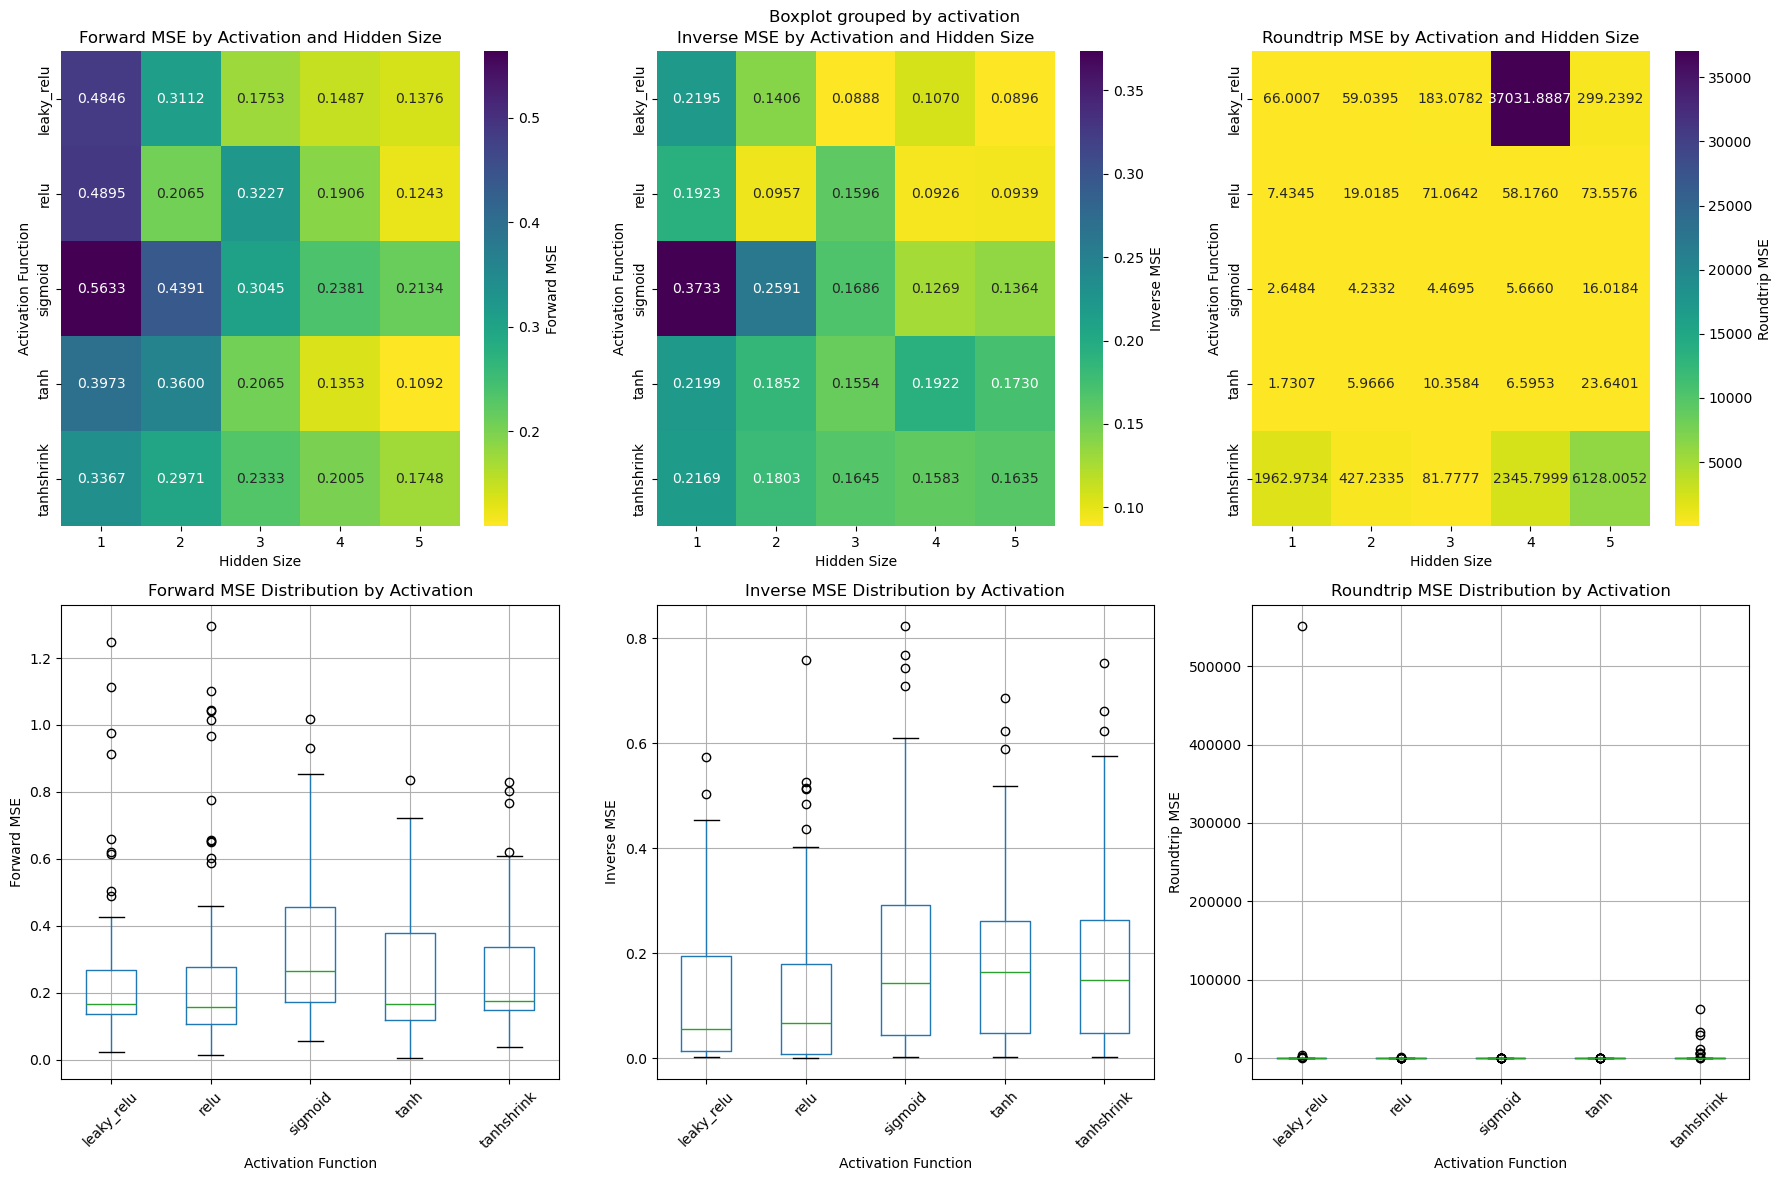


SUMMARY STATISTICS

Overall Statistics:
Forward Mse:
  Mean: 0.272011
  Median: 0.172976
  Std: 0.229048
  Min: 0.005424
  Max: 1.294695
  Success Rate (< 0.01): 0.5%
Inverse Mse:
  Mean: 0.166125
  Median: 0.116119
  Std: 0.174602
  Min: 0.000236
  Max: 0.823240
  Success Rate (< 0.01): 21.1%
Roundtrip Mse:
  Mean: 1955.824536
  Median: 7.671153
  Std: 28704.353726
  Min: 0.433137
  Max: 550885.187500
  Success Rate (< 0.01): 0.0%

Parameter Impact Analysis:

Hidden Size Impact on Forward MSE:
  1: 0.454259 ± 0.257041
  2: 0.322787 ± 0.169665
  3: 0.248486 ± 0.156102
  4: 0.182651 ± 0.089679
  5: 0.151873 ± 0.089157

Activation Impact on Forward MSE:
  leaky_relu: 0.251492 ± 0.183113
  relu: 0.266736 ± 0.237440
  sigmoid: 0.351694 ± 0.219084
  tanh: 0.241656 ± 0.167563
  tanhshrink: 0.248477 ± 0.147739

Num Iterations Impact on Forward MSE:
  1: 0.161100 ± 0.006819
  2: 0.177049 ± 0.112114
  3: 0.219719 ± 0.153537
  4: 0.372244 ± 0.235824
  5: 0.429943 ± 0.207660

Summary saved to: /

In [ ]:
import seaborn as sns
# Analyze Hyperparameter Tuning Results
def analyze_hyperparameter_results(csv_filename):
    """Analyze the results from hyperparameter tuning CSV file"""
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Read the CSV file
    df = pd.read_csv(csv_filename)
    
    print(f"Loaded {len(df)} results from {csv_filename}")
    print(f"Unique configurations: {len(df.groupby(['hidden_size', 'activation', 'num_iterations']))}")
    print("="*60)
    
    # Calculate average results for each configuration
    avg_results = df.groupby(['hidden_size', 'activation', 'num_iterations']).agg({
        'forward_mse': ['mean', 'std'],
        'inverse_mse': ['mean', 'std'],
        'roundtrip_mse': ['mean', 'std'],
        'final_loss': ['mean', 'std'],
        'runtime_seconds': ['mean', 'std']
    }).round(6)
    
    # Flatten column names
    avg_results.columns = ['_'.join(col).strip() for col in avg_results.columns]
    avg_results = avg_results.reset_index()
    
    # Find best configurations
    best_configs = {
        'forward': avg_results.loc[avg_results['forward_mse_mean'].idxmin()],
        'inverse': avg_results.loc[avg_results['inverse_mse_mean'].idxmin()],
        'roundtrip': avg_results.loc[avg_results['roundtrip_mse_mean'].idxmin()]
    }
    
    print("Best Average Configurations:")
    for metric, config in best_configs.items():
        print(f"\nBest {metric.capitalize()} MSE: {config[f'{metric}_mse_mean']:.6f} ± {config[f'{metric}_mse_std']:.6f}")
        print(f"  hidden_size: {config['hidden_size']}")
        print(f"  activation: {config['activation']}")
        print(f"  num_iterations: {config['num_iterations']}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Heatmaps for each MSE metric
    metrics = ['forward_mse_mean', 'inverse_mse_mean', 'roundtrip_mse_mean']
    metric_names = ['Forward MSE', 'Inverse MSE', 'Roundtrip MSE']
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        # Create pivot table for heatmap
        pivot = avg_results.pivot_table(values=metric, 
                                       index='activation', 
                                       columns='hidden_size', 
                                       aggfunc='mean')
        
        sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis_r', 
                   ax=axes[0, i], cbar_kws={'label': name})
        axes[0, i].set_title(f'{name} by Activation and Hidden Size')
        axes[0, i].set_xlabel('Hidden Size')
        axes[0, i].set_ylabel('Activation Function')
    
    # Box plots for each metric
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        df.boxplot(column=metric.replace('_mean', ''), by='activation', ax=axes[1, i])
        axes[1, i].set_title(f'{name} Distribution by Activation')
        axes[1, i].set_xlabel('Activation Function')
        axes[1, i].set_ylabel(name)
        axes[1, i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    print(f"\nOverall Statistics:")
    for metric in ['forward_mse', 'inverse_mse', 'roundtrip_mse']:
        values = df[metric]
        print(f"{metric.replace('_', ' ').title()}:")
        print(f"  Mean: {values.mean():.6f}")
        print(f"  Median: {values.median():.6f}")
        print(f"  Std: {values.std():.6f}")
        print(f"  Min: {values.min():.6f}")
        print(f"  Max: {values.max():.6f}")
        print(f"  Success Rate (< 0.01): {(values < 0.01).mean()*100:.1f}%")
    
    # Parameter impact analysis
    print(f"\nParameter Impact Analysis:")
    for param in ['hidden_size', 'activation', 'num_iterations']:
        param_impact = avg_results.groupby(param)['forward_mse_mean'].agg(['mean', 'std'])
        print(f"\n{param.replace('_', ' ').title()} Impact on Forward MSE:")
        for idx, row in param_impact.iterrows():
            print(f"  {idx}: {row['mean']:.6f} ± {row['std']:.6f}")
    
    # Save summary to file
    summary_filename = csv_filename.replace('.csv', '_summary.csv')
    avg_results.to_csv(summary_filename, index=False)
    print(f"\nSummary saved to: {summary_filename}")
    
    return avg_results

# Example usage (uncomment after running hyperparameter tuning):
results_df = analyze_hyperparameter_results('/home/kjmetzler/4f-files/../results/hyperparameter_results_20250812_111536.csv')